Here is a summary of the LastFM dataset in a table format, including the exploration results and reasons for its heterogeneity:

### Summary of LastFM Dataset

| Aspect                         | Details                                                                                 |
|--------------------------------|-----------------------------------------------------------------------------------------|
| Number of Users                | 1892                                                                                    |
| Number of Artists              | 17632                                                                                   |
| Number of Tags                 | 1088                                                                                    |
| Number of Edges                | 201908                                                                                  |
| Number of Nodes                | 20612                                                                                   |
| Edge Types                     | 5 types: ('user', 'to', 'artist'), ('user', 'to', 'user'), ('artist', 'to', 'user'), ('artist', 'to', 'tag'), ('tag', 'to', 'artist') |
| Features per Node              | {'user': 0, 'artist': 0, 'tag': 0}                                                      |
| Features per Edge              | {('user', 'to', 'artist'): 0, ('user', 'to', 'user'): 0, ('artist', 'to', 'user'): 0, ('artist', 'to', 'tag'): 0, ('tag', 'to', 'artist'): 0} |
| Train Positive Edge Index      | 80% of the edges                                                                         |
| Validation Positive Edge Index | 10% of the edges                                                                         |
| Test Positive Edge Index       | 10% of the edges                                                                         |

### Reason for Heterogeneity

The LastFM dataset is considered heterogeneous because it consists of multiple types of nodes and edges. Specifically:

- **Node Types**: Users, Artists, Tags.
- **Edge Types**: Relationships such as 'user-to-artist', 'user-to-user', 'artist-to-user', 'artist-to-tag', and 'tag-to-artist'.

This diversity in node and edge types allows the dataset to represent complex interactions and relationships between different entities in the graph, making it suitable for various types of analysis and machine learning tasks, including link prediction.

### Suitability for Link Prediction

Yes, the LastFM dataset can be used for link prediction tasks. In link prediction, the goal is to predict the existence of a relationship (edge) between two nodes in a graph. The dataset's structure, with its multiple types of nodes and edges and the availability of positive and negative edge indices for training, validation, and testing, makes it well-suited for this purpose. The RandomLinkSplit transform is used to create train, validation, and test splits, which is essential for evaluating link prediction models.

### Heterogeneous Graph Learning

Heterogeneous graphs are important in scenarios where the relationships between different types of entities need to be understood and predicted. By using heterogeneous graph neural networks (HGNNs) or other machine learning techniques tailored for heterogeneous data, one can leverage the rich information encapsulated in the different types of nodes and edges to improve prediction performance.

This dataset's heterogeneity and its application to link prediction tasks make it a valuable resource for researchers and practitioners working on recommendation systems, user behavior modeling, and other related fields.

# LastFM 
# Amazon-book
# Yahoo-Music
# IMDB
# OGB -BIOKG

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import AmazonBook
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Check for MPS availability and set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the AmazonBook dataset
root_path = osp.join('data', 'AmazonBook')
dataset = AmazonBook(root=root_path, force_reload=True)
data = dataset[0]

# Print dataset statistics
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node types: {data.node_types}")
print(f"Edge types: {data.edge_types}")
print(f"Node features: {data.num_node_features}")
print(f"Edge features: {data.num_edge_features}")


Using device: mps


Processing...


Number of nodes: 144242
Number of edges: 4761460
Node types: ['user', 'book']
Edge types: [('user', 'rates', 'book'), ('book', 'rated_by', 'user')]
Node features: {'user': 0, 'book': 0}
Edge features: {('user', 'rates', 'book'): 0, ('book', 'rated_by', 'user'): 0}


Done!


In [2]:
import torch
from ogb.linkproppred import PygLinkPropPredDataset
import os.path as osp

# Load the ogbl-biokg dataset
path = osp.join('data', 'ogbl-biokg')
dataset = PygLinkPropPredDataset(name='ogbl-biokg', root=path)
data = dataset[0]

# Print basic details about the data
print("Node types and counts:", data.num_nodes_dict)
print("Edge types and their indices:", data.edge_index_dict.keys())

# Example: Accessing edge indices for 'disease-protein' relationship
edge_type = ('disease', 'disease-protein', 'protein')
if edge_type in data.edge_index_dict:
    edge_index = data.edge_index_dict[edge_type]
    print(f"Edge type {edge_type} with edge indices shape: {edge_index.shape}")
    print(f"Sample edge indices for {edge_type}:")
    print(edge_index[:, :10])  # Print first 10 edges
else:
    print(f"Edge type {edge_type} not found in the dataset.")

# Check and print details for each edge type
for edge_type, edge_index in data.edge_index_dict.items():
    print(f"Edge type {edge_type} with edge indices shape: {edge_index.shape}")

# Verify there are no node features
node_types_with_features = ['disease', 'drug', 'function', 'protein', 'sideeffect']
for node_type in node_types_with_features:
    if node_type in data:
        try:
            node_features = data[node_type].x
            print(f"Node type '{node_type}' has node features with shape {node_features.shape}.")
        except KeyError:
            print(f"Node type '{node_type}' does not have node features.")
        except AttributeError:
            print(f"Node type '{node_type}' does not have 'x' attribute.")
    else:
        print(f"Node type '{node_type}' not found in data storage.")

Node types and counts: {'disease': 10687, 'drug': 10533, 'function': 45085, 'protein': 17499, 'sideeffect': 9969}
Edge types and their indices: dict_keys([('disease', 'disease-protein', 'protein'), ('drug', 'drug-disease', 'disease'), ('drug', 'drug-drug_acquired_metabolic_disease', 'drug'), ('drug', 'drug-drug_bacterial_infectious_disease', 'drug'), ('drug', 'drug-drug_benign_neoplasm', 'drug'), ('drug', 'drug-drug_cancer', 'drug'), ('drug', 'drug-drug_cardiovascular_system_disease', 'drug'), ('drug', 'drug-drug_chromosomal_disease', 'drug'), ('drug', 'drug-drug_cognitive_disorder', 'drug'), ('drug', 'drug-drug_cryptorchidism', 'drug'), ('drug', 'drug-drug_developmental_disorder_of_mental_health', 'drug'), ('drug', 'drug-drug_endocrine_system_disease', 'drug'), ('drug', 'drug-drug_fungal_infectious_disease', 'drug'), ('drug', 'drug-drug_gastrointestinal_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_system_diseas

In [3]:
import torch
from torch_geometric.datasets import IMDB
import os.path as osp

# Load the IMDB dataset
root_path = osp.join('IMDB')
dataset = IMDB(root=root_path)
data = dataset[0]

# Print the basic information about the dataset
print("Dataset: ", dataset)
print("Number of graphs in the dataset: ", len(dataset))
print("Dataset description: ", dataset.__repr__())

# Print the data object to understand its attributes
print("\nData object: ", data)

# Print the number of nodes and edges
print("\nNumber of nodes: ", data.num_nodes)
print("Number of edges: ", data.num_edges)

# Print node feature matrices and edge indices for each node and edge type
for node_type in data.node_types:
    print(f"\nNode type '{node_type}':")
    print(f"Number of nodes: {data[node_type].num_nodes}")
    print(f"Node feature matrix (first 5 nodes): {data[node_type].x[:5]}")

for edge_type in data.edge_types:
    print(f"\nEdge type '{edge_type}':")
    print(f"Edge index: {data[edge_type].edge_index}")
    print(f"Number of edges: {data[edge_type].num_edges}")

# Print the node types
print("\nNode types: ")
print(data.node_types)

# Print the edge types
print("\nEdge types: ")
print(data.edge_types)


Dataset:  IMDB()
Number of graphs in the dataset:  1
Dataset description:  IMDB()

Data object:  HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

Number of nodes:  11616
Number of edges:  34212

Node type 'movie':
Number of nodes: 4278
Node feature matrix (first 5 nodes): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Node type 'director':
Number of nodes: 2081
Node feature matrix (first 5 nodes): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

In [2]:
import torch
from torch_geometric.datasets import LastFM
import os.path as osp

# Load the LastFM dataset
root_path = osp.join('data', 'LastFM')  # Adjust the path as necessary
dataset = LastFM(root=root_path)
data = dataset[0]

# Check available keys in the dataset
print(f'Keys in data: {data.keys}')

# Accessing the number of users and artists
print(f'Number of users: {data["user"].num_nodes}')
print(f'Number of artists: {data["artist"].num_nodes}')

# Check the keys available in the edge type "user", "listens", "artist"
print(f'Keys in "user", "listens", "artist": {data["user", "listens", "artist"].keys()}')

# Now access the edge index and edge attributes correctly
if 'edge_index' in data['user', 'listens', 'artist']:
    print(f'Number of interactions: {data["user", "listens", "artist"].edge_index.size(1)}')
    print(f'Edge Index (user to artist):\n{data["user", "listens", "artist"].edge_index}')
else:
    print('Edge index not found for "user", "listens", "artist".')

if 'edge_attr' in data['user', 'listens', 'artist']:
    print(f'Edge Attributes (listens):\n{data["user", "listens", "artist"].edge_attr}')
else:
    print('Edge attributes not found for "user", "listens", "artist".')


Keys in data: <bound method BaseData.keys of HeteroData(
  user={ num_nodes=1892 },
  artist={ num_nodes=17632 },
  tag={ num_nodes=1088 },
  (user, to, artist)={
    train_neg_edge_index=[2, 33294760],
    val_pos_edge_index=[2, 9283],
    val_neg_edge_index=[2, 9283],
    test_pos_edge_index=[2, 18567],
    test_neg_edge_index=[2, 18567],
    edge_index=[2, 64984],
  },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, to, user)={ edge_index=[2, 64984] },
  (artist, to, tag)={ edge_index=[2, 23253] },
  (tag, to, artist)={ edge_index=[2, 23253] }
)>
Number of users: 1892
Number of artists: 17632
Keys in "user", "listens", "artist": KeysView({})
Edge index not found for "user", "listens", "artist".
Edge attributes not found for "user", "listens", "artist".


# Hello H r u?

In [27]:
import torch
from torch_geometric.datasets import LastFM
import os.path as osp
from torch_geometric.transforms import RandomLinkSplit

# Load the LastFM dataset
root_path = osp.join('data', 'LastFM')  # Adjust the path as necessary
dataset = LastFM(root=root_path)
data = dataset[0]

# Check available keys in the dataset
print(f'Keys in data: {data.keys}')

# Accessing the number of users, artists, and tags
print(f'Number of users: {data["user"].num_nodes}')
print(f'Number of artists: {data["artist"].num_nodes}')
print(f'Number of tags: {data["tag"].num_nodes}')

# Check the keys available in the edge type "user", "listens", "artist"
print('Checking edge types and their attributes...')
for edge_type in data.edge_types:
    print(f'Edge type: {edge_type}')
    if 'edge_index' in data[edge_type]:
        print(f'Number of edges in {edge_type}: {data[edge_type]["edge_index"].size(1)}')
        print(f'Edge Index for {edge_type}:\n{data[edge_type]["edge_index"]}')
    else:
        print(f'Edge index not found for {edge_type}.')
    
    if 'edge_attr' in data[edge_type]:
        print(f'Edge Attributes for {edge_type}:\n{data[edge_type]["edge_attr"]}')
    else:
        print(f'Edge attributes not found for {edge_type}.')

# Check some basic attributes of the graph
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')
print(f'Number of features per edge: {data.num_edge_features}')

# Use RandomLinkSplit to create train, validation, and test splits
edge_types = ('user', 'to', 'artist')  # Define the edge type
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[edge_types])
train_data, val_data, test_data = transform(data)

# Print the edge indices for train, validation, and test sets from the splits
print(f'Train positive edge index:\n{train_data[edge_types].edge_index}')
print(f'Validation positive edge index:\n{val_data[edge_types].edge_index}')
print(f'Test positive edge index:\n{test_data[edge_types].edge_index}')


Keys in data: ['train_neg_edge_index', 'val_pos_edge_index', 'test_neg_edge_index', 'test_pos_edge_index', 'val_neg_edge_index', 'num_nodes', 'edge_index']
Number of users: 1892
Number of artists: 17632
Number of tags: 1088
Checking edge types and their attributes...
Edge type: ('user', 'to', 'artist')
Number of edges in ('user', 'to', 'artist'): 64984
Edge Index for ('user', 'to', 'artist'):
tensor([[    0,     0,     0,  ...,  1891,  1891,  1891],
        [   45,    46,    47,  ..., 17617, 17618, 17619]])
Edge attributes not found for ('user', 'to', 'artist').
Edge type: ('user', 'to', 'user')
Number of edges in ('user', 'to', 'user'): 25434
Edge Index for ('user', 'to', 'user'):
tensor([[   0,    0,    0,  ..., 1890, 1891, 1891],
        [ 257,  400,  482,  ..., 1816,  548,  564]])
Edge attributes not found for ('user', 'to', 'user').
Edge type: ('artist', 'to', 'user')
Number of edges in ('artist', 'to', 'user'): 64984
Edge Index for ('artist', 'to', 'user'):
tensor([[    0,     0,

In [47]:
import torch
from torch_geometric.datasets import LastFM
from torch_geometric.transforms import RandomLinkSplit
import os.path as osp
from torch_geometric.utils import negative_sampling

# Load the LastFM dataset
root_path = osp.join('data', 'LastFM')
dataset = LastFM(root=root_path)
data = dataset[0]

# Check available keys in the dataset
print(f'Keys in data: {data.keys}')

# Accessing the number of users, artists, and tags
print(f'Number of users: {data["user"].num_nodes}')
print(f'Number of artists: {data["artist"].num_nodes}')
print(f'Number of tags: {data["tag"].num_nodes}')

# Check the edge types and their attributes
print('Checking edge types and their attributes...')
for edge_type in data.edge_types:
    print(f'Edge type: {edge_type}')
    if 'edge_index' in data[edge_type]:
        print(f'Number of edges in {edge_type}: {data[edge_type]["edge_index"].size(1)}')
        print(f'Edge Index for {edge_type}:\n{data[edge_type]["edge_index"]}')
    else:
        print(f'Edge index not found for {edge_type}.')

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'to', 'artist')])
train_data, val_data, test_data = transform(data)


Keys in data: ['train_neg_edge_index', 'val_pos_edge_index', 'test_neg_edge_index', 'test_pos_edge_index', 'val_neg_edge_index', 'num_nodes', 'edge_index']
Number of users: 1892
Number of artists: 17632
Number of tags: 1088
Checking edge types and their attributes...
Edge type: ('user', 'to', 'artist')
Number of edges in ('user', 'to', 'artist'): 64984
Edge Index for ('user', 'to', 'artist'):
tensor([[    0,     0,     0,  ...,  1891,  1891,  1891],
        [   45,    46,    47,  ..., 17617, 17618, 17619]])
Edge type: ('user', 'to', 'user')
Number of edges in ('user', 'to', 'user'): 25434
Edge Index for ('user', 'to', 'user'):
tensor([[   0,    0,    0,  ..., 1890, 1891, 1891],
        [ 257,  400,  482,  ..., 1816,  548,  564]])
Edge type: ('artist', 'to', 'user')
Number of edges in ('artist', 'to', 'user'): 64984
Edge Index for ('artist', 'to', 'user'):
tensor([[    0,     0,     0,  ..., 17629, 17630, 17631],
        [   31,   256,   729,  ...,   423,   423,   547]])
Edge type: ('ar

import torch
import torch.nn.functional as F
from torch_geometric.datasets import LastFM
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import HGTConv
from torch_geometric.utils import negative_sampling
import os.path as osp

# Load the LastFM dataset
root_path = osp.join('data', 'LastFM')
dataset = LastFM(root=root_path)
data = dataset[0]

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Check available keys in the dataset
print(f'Keys in data: {list(data.keys)}')

# Accessing the number of users, artists, and tags
print(f'Number of users: {data["user"].num_nodes}')
print(f'Number of artists: {data["artist"].num_nodes}')
print(f'Number of tags: {data["tag"].num_nodes}')

# Check the edge types and their attributes
print('Checking edge types and their attributes...')
for edge_type in data.edge_types:
    print(f'Edge type: {edge_type}')
    if 'edge_index' in data[edge_type]:
        print(f'Number of edges in {edge_type}: {data[edge_type]["edge_index"].size(1)}')
        print(f'Edge Index for {edge_type}:\n{data[edge_type]["edge_index"]}')
    else:
        print(f'Edge index not found for {edge_type}.')

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'to', 'artist')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        print(f'Initializing HGTConv with in_channels: {{node_type: -1 for node_type in metadata[0]}}, hidden_channels: {hidden_channels}, metadata: {metadata}, num_heads: {num_heads}')
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            print(f'Initializing HGTConv with in_channels: {{node_type: hidden_channels for node_type in metadata[0]}}, hidden_channels: {hidden_channels}, metadata: {metadata}, num_heads: {num_heads}')
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))
print(f'Metadata: {metadata}')

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    print(f'x_dict before forward: {train_data.x_dict}')
    print(f'edge_index_dict before forward: {train_data.edge_index_dict}')
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'to', 'artist'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['artist'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['artist'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['artist'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 2):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def test(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'to', 'artist'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['artist'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['artist'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['artist'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_pred = pos_out > 0
    neg_pred = neg_out < 0
    correct = pos_pred.sum() + neg_pred.sum()
    total = pos_pred.size(0) + neg_pred.size(0)
    return correct / total

# Evaluate the model
val_acc = test(val_data)
test_acc = test(test_data)
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')



Keys in data: ['x', 'train_neg_edge_index', 'val_pos_edge_index', 'test_neg_edge_index', 'test_pos_edge_index', 'val_neg_edge_index', 'num_nodes', 'edge_index']
Number of users: 1892
Number of artists: 17632
Number of tags: 1088
Checking edge types and their attributes...
Edge type: ('user', 'to', 'artist')
Number of edges in ('user', 'to', 'artist'): 64984
Edge Index for ('user', 'to', 'artist'):
tensor([[    0,     0,     0,  ...,  1891,  1891,  1891],
        [   45,    46,    47,  ..., 17617, 17618, 17619]])
Edge type: ('user', 'to', 'user')
Number of edges in ('user', 'to', 'user'): 25434
Edge Index for ('user', 'to', 'user'):
tensor([[   0,    0,    0,  ..., 1890, 1891, 1891],
        [ 257,  400,  482,  ..., 1816,  548,  564]])
Edge type: ('artist', 'to', 'user')
Number of edges in ('artist', 'to', 'user'): 64984
Edge Index for ('artist', 'to', 'user'):
tensor([[    0,     0,     0,  ..., 17629, 17630, 17631],
        [   31,   256,   729,  ...,   423,   423,   547]])
Edge type: ('artist', 'to', 'tag')
Number of edges in ('artist', 'to', 'tag'): 23253
Edge Index for ('artist', 'to', 'tag'):
tensor([[    0,     0,     0,  ..., 17602, 17604, 17604],
        [   86,    88,   101,  ...,    13,    13,    19]])
Edge type: ('tag', 'to', 'artist')
Number of edges in ('tag', 'to', 'artist'): 23253
Edge Index for ('tag', 'to', 'artist'):
tensor([[   0,    0,    0,  ..., 1085, 1086, 1087],
        [   3,    6,    7,  ..., 6691,  695, 1105]])
Metadata: (['user', 'artist', 'tag'], [('user', 'to', 'artist'), ('user', 'to', 'user'), ('artist', 'to', 'user'), ('artist', 'to', 'tag'), ('tag', 'to', 'artist')])
Initializing HGTConv with in_channels: {node_type: -1 for node_type in metadata[0]}, hidden_channels: 60, metadata: (['user', 'artist', 'tag'], [('user', 'to', 'artist'), ('user', 'to', 'user'), ('artist', 'to', 'user'), ('artist', 'to', 'tag'), ('tag', 'to', 'artist')]), num_heads: 5
Initializing HGTConv with in_channels: {node_type: hidden_channels for node_type in metadata[0]}, hidden_channels: 60, metadata: (['user', 'artist', 'tag'], [('user', 'to', 'artist'), ('user', 'to', 'user'), ('artist', 'to', 'user'), ('artist', 'to', 'tag'), ('tag', 'to', 'artist')]), num_heads: 5
x_dict before forward: {'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'artist': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'tag': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])}
edge_index_dict before forward: {('user', 'to', 'artist'): tensor([[  869,  1574,  1310,  ...,  1105,  1506,  1256],
        [  406,  3465,  5844,  ...,   211, 15176,  9721]]), ('user', 'to', 'user'): tensor([[   0,    0,    0,  ..., 1890, 1891, 1891],
        [ 257,  400,  482,  ..., 1816,  548,  564]]), ('artist', 'to', 'user'): tensor([[    0,     0,     0,  ..., 17629, 17630, 17631],
        [   31,   256,   729,  ...,   423,   423,   547]]), ('artist', 'to', 'tag'): tensor([[    0,     0,     0,  ..., 17602, 17604, 17604],
        [   86,    88,   101,  ...,    13,    13,    19]]), ('tag', 'to', 'artist'): tensor([[   0,    0,    0,  ..., 1085, 1086, 1087],
        [   3,    6,    7,  ..., 6691,  695, 1105]])}
Epoch: 1, Loss: 1.3868
Validation Accuracy: 0.9190
Test Accuracy: 0.9181

Epoch: 1, Loss: 1.3870
Epoch: 2, Loss: 1.3863
Epoch: 3, Loss: 1.3861
Epoch: 4, Loss: 1.3858
Epoch: 5, Loss: 1.3853
Epoch: 6, Loss: 1.3841
Epoch: 7, Loss: 1.3817
Epoch: 8, Loss: 1.3767
Epoch: 9, Loss: 1.3661
Epoch: 10, Loss: 1.3482
Epoch: 11, Loss: 1.3164
Epoch: 12, Loss: 1.2818
Epoch: 13, Loss: 1.2753
Epoch: 14, Loss: 1.2664
Epoch: 15, Loss: 1.2694
Epoch: 16, Loss: 1.2680
Epoch: 17, Loss: 1.2607
Epoch: 18, Loss: 1.2494
Epoch: 19, Loss: 1.2460
Validation AUC: 0.7262, Macro F1: 0.5292, Micro F1: 0.6893
Test AUC: 0.7396, Macro F1: 0.5249, Micro F1: 0.6704


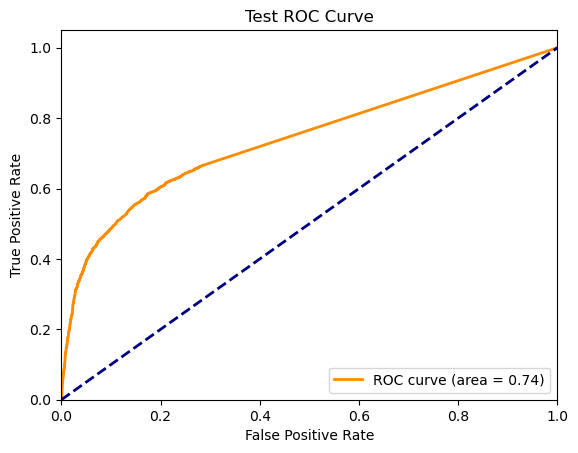

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import LastFM
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import HGTConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the LastFM dataset
root_path = osp.join('data', 'LastFM')
dataset = LastFM(root=root_path)
data = dataset[0]

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'to', 'artist')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'to', 'artist'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['artist'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['artist'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['artist'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 20):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'to', 'artist'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['artist'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['artist'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['artist'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr_lastfm, tpr_lastfm, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr_lastfm, tpr_lastfm)
    
    plt.figure()
    plt.plot(fpr_lastfm, tpr_lastfm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve
plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


In [3]:
import os
from torch_geometric.datasets import IGMCDataset

# Set the root directory where the dataset should be saved
root_path = osp.join('data', 'Yahoo-Music')

# Load the Yahoo-Music dataset
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')

# Access the first graph in the dataset
data = dataset[0]

# Print dataset information
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node types: {data.node_types}")
print(f"Edge types: {data.edge_types}")

# Inspect the data
print(data)


Processing...


Number of nodes: 6000
Number of edges: 9604
Node types: ['user', 'item']
Edge types: [('user', 'rates', 'item'), ('item', 'rated_by', 'user')]
HeteroData(
  user={ x=[3000, 3000] },
  item={ x=[3000, 3000] },
  (user, rates, item)={
    edge_index=[2, 4802],
    rating=[4802],
    edge_label_index=[2, 533],
    edge_label=[533],
  },
  (item, rated_by, user)={
    edge_index=[2, 4802],
    rating=[4802],
  }
)


Done!


Adjusting edge labels for ('user', 'rates', 'item')
Epoch: 1, Loss: 1.3863
Epoch: 2, Loss: 1.3716
Epoch: 3, Loss: 1.3363
Epoch: 4, Loss: 1.2474
Epoch: 5, Loss: 1.1700
Epoch: 6, Loss: 1.1387
Epoch: 7, Loss: 1.1276
Epoch: 8, Loss: 1.1356
Epoch: 9, Loss: 1.0774
Validation AUC: 0.9650, Macro F1: 0.4444, Micro F1: 0.7998
Test AUC: 0.9537, Macro F1: 0.4436, Micro F1: 0.7973


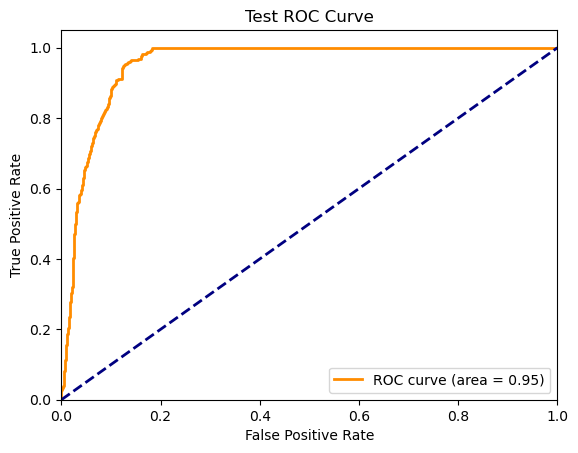

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        print(f"Adjusting edge labels for {edge_type}")
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve
plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


# With both edge lebels , yahoo music

* This code focuses on predicting links specifically for the ('user', 'rates', 'item') edge type in the Yahoo-Music dataset while ensuring that edge labels for both ('user', 'rates', 'item') and ('item', 'rated_by', 'user') are correctly assigned and consistent. The link prediction is performed by training an HGT (Heterogeneous Graph Transformer) model, which processes the node features and edge indices, and computes positive and negative edge predictions for the ('user', 'rates', 'item') type. During evaluation, it measures performance metrics (ROC AUC and F1 scores) for the predictions and plots the ROC curve, ensuring that the focus remains on the user-item interactions while maintaining data consistency for both edge types.
* The code provided primarily focuses on the ('user', 'rates', 'item') edge type for link prediction. The ('item', 'rated_by', 'user') edge type is not explicitly used for link prediction but is ensured to have correct labels to maintain consistency in the dataset. Here's a breakdown of how these edge types are treated:

Ensuring Edge Labels:

Both ('user', 'rates', 'item') and ('item', 'rated_by', 'user') edge types are checked to ensure they have correct edge labels.
Training and Evaluation:

The link prediction task focuses on the ('user', 'rates', 'item') edge type.
Positive samples are taken from the ('user', 'rates', 'item') edge type.
Negative samples are generated using the negative_sampling function, which creates edges that do not exist in the original graph. These negative samples are derived based on the ('user', 'rates', 'item') edge type and not explicitly from ('item', 'rated_by', 'user').
The ('item', 'rated_by', 'user') edge type is treated as part of the dataset structure, ensuring correct labels and data consistency, but it is not directly used as negative samples. Negative samples are generated independently from both edge types, focusing on creating non-existent edges to test the model's ability to distinguish between true and false links.








Adjusting edge labels for ('user', 'rates', 'item')
Epoch: 1, Loss: 1.3877
Epoch: 2, Loss: 1.3758
Epoch: 3, Loss: 1.3454
Epoch: 4, Loss: 1.2739
Epoch: 5, Loss: 1.1414
Epoch: 6, Loss: 1.3989
Epoch: 7, Loss: 1.1334
Epoch: 8, Loss: 1.1679
Epoch: 9, Loss: 1.2063
Validation AUC: 0.9578, Macro F1: 0.4460, Micro F1: 0.8049
Test AUC: 0.9474, Macro F1: 0.4458, Micro F1: 0.8042


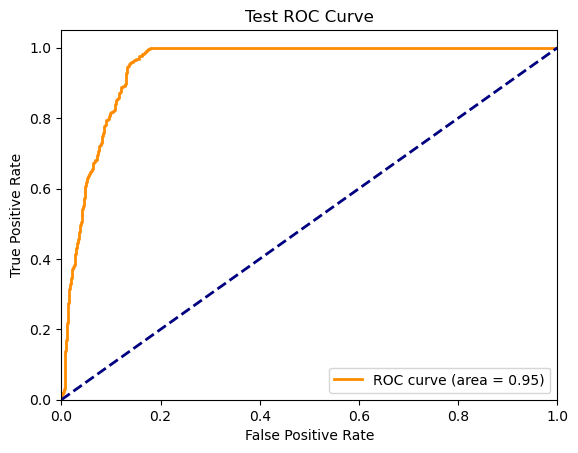

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        print(f"Adjusting edge labels for {edge_type}")
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve and get fpr, tpr
fpr_yahoo, tpr_yahoo = plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


Adjusting edge labels for ('user', 'rates', 'item')
Epoch: 1, Loss: 1.3856
Epoch: 2, Loss: 1.3695
Epoch: 3, Loss: 1.3196
Epoch: 4, Loss: 1.2171
Epoch: 5, Loss: 1.3112
Epoch: 6, Loss: 1.1382
Epoch: 7, Loss: 1.1587
Epoch: 8, Loss: 1.1708
Epoch: 9, Loss: 1.1668
Epoch: 10, Loss: 1.1342
Epoch: 11, Loss: 1.1342
Epoch: 12, Loss: 1.1308
Epoch: 13, Loss: 1.0926
Epoch: 14, Loss: 1.0792
Epoch: 15, Loss: 1.0821
Epoch: 16, Loss: 1.0721
Epoch: 17, Loss: 1.0703
Epoch: 18, Loss: 1.0428
Epoch: 19, Loss: 1.0310
Validation AUC: 0.9483, Macro F1: 0.4407, Micro F1: 0.7879
Test AUC: 0.9568, Macro F1: 0.4431, Micro F1: 0.7955


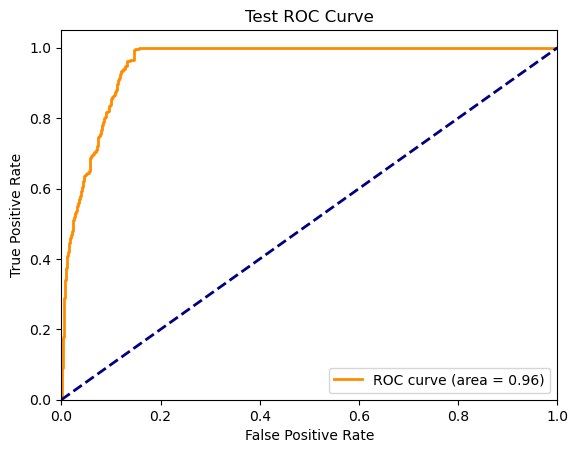

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        print(f"Adjusting edge labels for {edge_type}")
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))

    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 20):  # Increase number of epochs for better training
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve and get fpr, tpr
fpr_yahoo, tpr_yahoo = plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


Adjusting edge labels for ('user', 'rates', 'item')
Epoch: 1, Loss: 1.3862
Epoch: 2, Loss: 1.3710
Epoch: 3, Loss: 1.3302
Epoch: 4, Loss: 1.3039
Epoch: 5, Loss: 1.1788
Epoch: 6, Loss: 1.1473
Epoch: 7, Loss: 1.1347
Epoch: 8, Loss: 1.1312
Epoch: 9, Loss: 1.1196
Validation AUC: 0.9648, Macro F1: 0.4444, Micro F1: 0.7998
Test AUC: 0.9602, Macro F1: 0.4443, Micro F1: 0.7996


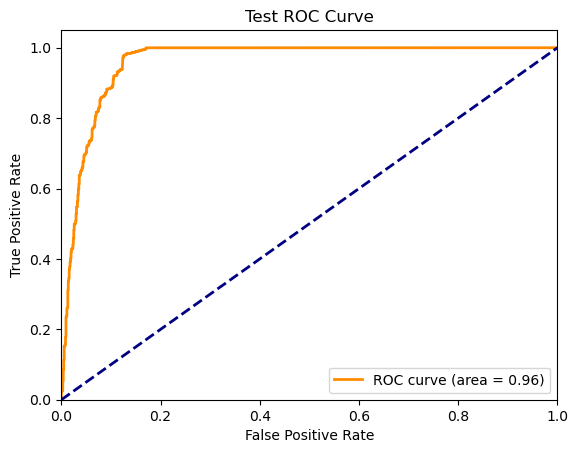

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        print(f"Adjusting edge labels for {edge_type}")
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve and get fpr, tpr
fpr_yahoo, tpr_yahoo = plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


Epoch: 1, Loss: 1.3866
Epoch: 2, Loss: 1.3711
Epoch: 3, Loss: 1.3360
Epoch: 4, Loss: 1.2499
Epoch: 5, Loss: 1.1833
Epoch: 6, Loss: 1.1545
Epoch: 7, Loss: 1.1405
Epoch: 8, Loss: 1.1422
Epoch: 9, Loss: 1.1124
Validation AUC: 0.9571, Macro F1: 0.4440, Micro F1: 0.7984
Test AUC: 0.9499, Macro F1: 0.4441, Micro F1: 0.7989


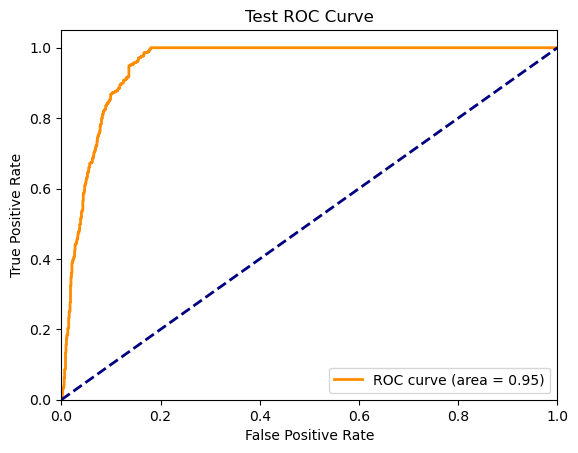

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present and properly sized for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

# Evaluation function
def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

# Function to plot ROC curve
def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve for the test set
plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


Adjusting edge labels for ('user', 'rates', 'item')
Epoch: 1, Loss: 2.7757
Epoch: 2, Loss: 2.7468
Epoch: 3, Loss: 2.6745
Epoch: 4, Loss: 2.5299
Epoch: 5, Loss: 2.2622
Epoch: 6, Loss: 2.5103
Epoch: 7, Loss: 2.2372
Epoch: 8, Loss: 2.3099
Epoch: 9, Loss: 2.3522
Epoch: 10, Loss: 2.3208
Epoch: 11, Loss: 2.2413
Epoch: 12, Loss: 2.1571
Epoch: 13, Loss: 2.1668
Epoch: 14, Loss: 2.2011
Epoch: 15, Loss: 2.1426
Epoch: 16, Loss: 2.1019
Epoch: 17, Loss: 2.0993
Epoch: 18, Loss: 2.0785
Epoch: 19, Loss: 2.0693
Epoch: 20, Loss: 2.0172
Epoch: 21, Loss: 1.9752
Epoch: 22, Loss: 1.9877
Epoch: 23, Loss: 1.9615
Epoch: 24, Loss: 1.9698
Epoch: 25, Loss: 1.8586
Epoch: 26, Loss: 1.9120
Epoch: 27, Loss: 1.8822
Epoch: 28, Loss: 1.9051
Epoch: 29, Loss: 1.8061
Epoch: 30, Loss: 1.8160
Epoch: 31, Loss: 1.7892
Epoch: 32, Loss: 1.7839
Epoch: 33, Loss: 1.7715
Epoch: 34, Loss: 1.7808
Epoch: 35, Loss: 1.7859
Epoch: 36, Loss: 1.7419
Epoch: 37, Loss: 1.7444
Epoch: 38, Loss: 1.7351
Epoch: 39, Loss: 1.7201
Epoch: 40, Loss: 1.73

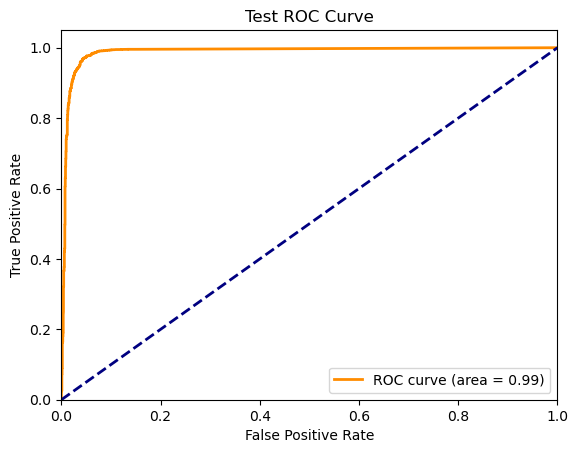

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        print(f"Adjusting edge labels for {edge_type}")
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item'), ('item', 'rated_by', 'user')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    
    # Handle both edge types
    pos_edge_index_user_item = train_data['user', 'rates', 'item'].edge_index
    pos_edge_index_item_user = train_data['item', 'rated_by', 'user'].edge_index
    
    neg_edge_index_user_item = negative_sampling(edge_index=pos_edge_index_user_item, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index_user_item.size(1))
    neg_edge_index_item_user = negative_sampling(edge_index=pos_edge_index_item_user, num_nodes=(data['item'].num_nodes + data['user'].num_nodes), num_neg_samples=pos_edge_index_item_user.size(1))

    # Filter out invalid negative samples
    neg_edge_index_user_item = neg_edge_index_user_item[:, (neg_edge_index_user_item[0] < data['user'].num_nodes) & (neg_edge_index_user_item[1] >= data['user'].num_nodes)]
    neg_edge_index_item_user = neg_edge_index_item_user[:, (neg_edge_index_item_user[0] < data['item'].num_nodes) & (neg_edge_index_item_user[1] >= data['item'].num_nodes)]
    
    pos_out_user_item = (pred['user'][pos_edge_index_user_item[0]] * pred['item'][pos_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out_user_item = (pred['user'][neg_edge_index_user_item[0]] * pred['item'][neg_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)

    pos_out_item_user = (pred['item'][pos_edge_index_item_user[0]] * pred['user'][pos_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)
    neg_out_item_user = (pred['item'][neg_edge_index_item_user[0]] * pred['user'][neg_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)

    pos_loss_user_item = criterion(pos_out_user_item, torch.ones_like(pos_out_user_item))
    neg_loss_user_item = criterion(neg_out_user_item, torch.zeros_like(neg_out_user_item))
    pos_loss_item_user = criterion(pos_out_item_user, torch.ones_like(pos_out_item_user))
    neg_loss_item_user = criterion(neg_out_item_user, torch.zeros_like(neg_out_item_user))

    loss = pos_loss_user_item + neg_loss_user_item + pos_loss_item_user + neg_loss_item_user
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 50):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    
    pos_edge_index_user_item = data['user', 'rates', 'item'].edge_index
    pos_edge_index_item_user = data['item', 'rated_by', 'user'].edge_index
    
    neg_edge_index_user_item = negative_sampling(edge_index=pos_edge_index_user_item, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index_user_item.size(1))
    neg_edge_index_item_user = negative_sampling(edge_index=pos_edge_index_item_user, num_nodes=(data['item'].num_nodes + data['user'].num_nodes), num_neg_samples=pos_edge_index_item_user.size(1))

    # Filter out invalid negative samples
    neg_edge_index_user_item = neg_edge_index_user_item[:, (neg_edge_index_user_item[0] < data['user'].num_nodes) & (neg_edge_index_user_item[1] >= data['user'].num_nodes)]
    neg_edge_index_item_user = neg_edge_index_item_user[:, (neg_edge_index_item_user[0] < data['item'].num_nodes) & (neg_edge_index_item_user[1] >= data['item'].num_nodes)]
    
    pos_out_user_item = (pred['user'][pos_edge_index_user_item[0]] * pred['item'][pos_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out_user_item = (pred['user'][neg_edge_index_user_item[0]] * pred['item'][neg_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)

    pos_out_item_user = (pred['item'][pos_edge_index_item_user[0]] * pred['user'][pos_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)
    neg_out_item_user = (pred['item'][neg_edge_index_item_user[0]] * pred['user'][neg_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)

    pos_labels_user_item = torch.ones(pos_out_user_item.size(0))
    neg_labels_user_item = torch.zeros(neg_out_user_item.size(0))
    pos_labels_item_user = torch.ones(pos_out_item_user.size(0))
    neg_labels_item_user = torch.zeros(neg_out_item_user.size(0))

    labels = torch.cat([pos_labels_user_item, neg_labels_user_item, pos_labels_item_user, neg_labels_item_user])
    preds = torch.cat([pos_out_user_item, neg_out_user_item, pos_out_item_user, neg_out_item_user])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve and get fpr, tpr
fpr_yahoo, tpr_yahoo = plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


Adjusting edge labels for ('user', 'rates', 'item')
Epoch: 1, Loss: 2.7721
Epoch: 2, Loss: 2.7398
Epoch: 3, Loss: 2.6283
Epoch: 4, Loss: 2.4100
Epoch: 5, Loss: 2.8905
Epoch: 6, Loss: 2.3009
Epoch: 7, Loss: 2.3560
Epoch: 8, Loss: 2.4687
Epoch: 9, Loss: 2.5004
Epoch: 10, Loss: 2.4987
Epoch: 11, Loss: 2.4649
Epoch: 12, Loss: 2.4112
Epoch: 13, Loss: 2.3062
Epoch: 14, Loss: 2.2047
Epoch: 15, Loss: 2.1980
Epoch: 16, Loss: 2.2286
Epoch: 17, Loss: 2.3009
Epoch: 18, Loss: 2.1501
Epoch: 19, Loss: 2.1112
Epoch: 20, Loss: 2.1351
Epoch: 21, Loss: 2.1505
Epoch: 22, Loss: 2.1137
Epoch: 23, Loss: 2.0794
Epoch: 24, Loss: 2.0305
Epoch: 25, Loss: 2.0241
Epoch: 26, Loss: 1.9679
Epoch: 27, Loss: 1.9804
Epoch: 28, Loss: 1.9893
Epoch: 29, Loss: 1.9330
Epoch: 30, Loss: 1.9048
Epoch: 31, Loss: 1.8913
Epoch: 32, Loss: 1.8548
Epoch: 33, Loss: 1.8440
Epoch: 34, Loss: 1.8191
Epoch: 35, Loss: 1.8108
Epoch: 36, Loss: 1.9171
Epoch: 37, Loss: 1.8639
Epoch: 38, Loss: 1.8459
Epoch: 39, Loss: 1.7831
Epoch: 40, Loss: 1.84

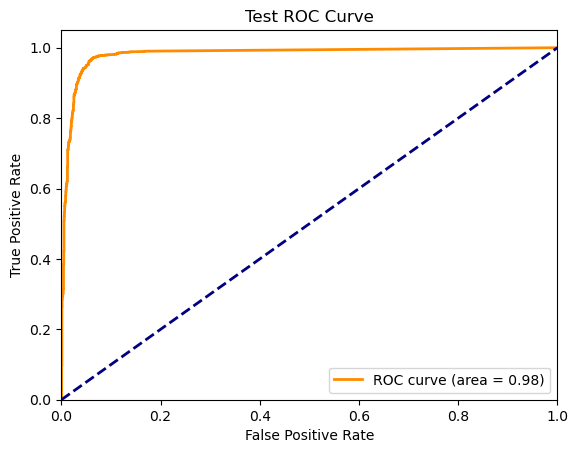

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Yahoo-Music dataset
root_path = osp.join('data', 'Yahoo-Music')
dataset = IGMCDataset(root=root_path, name='Yahoo-Music')
data = dataset[0]

# Ensure edge labels are present for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        print(f"Adjusting edge labels for {edge_type}")
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item'), ('item', 'rated_by', 'user')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    
    # Handle both edge types
    pos_edge_index_user_item = train_data['user', 'rates', 'item'].edge_index
    pos_edge_index_item_user = train_data['item', 'rated_by', 'user'].edge_index
    
    neg_edge_index_user_item = negative_sampling(edge_index=pos_edge_index_user_item, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index_user_item.size(1))
    neg_edge_index_item_user = negative_sampling(edge_index=pos_edge_index_item_user, num_nodes=(data['item'].num_nodes + data['user'].num_nodes), num_neg_samples=pos_edge_index_item_user.size(1))

    # Filter out invalid negative samples
    neg_edge_index_user_item = neg_edge_index_user_item[:, (neg_edge_index_user_item[0] < data['user'].num_nodes) & (neg_edge_index_user_item[1] >= data['user'].num_nodes)]
    neg_edge_index_item_user = neg_edge_index_item_user[:, (neg_edge_index_item_user[0] < data['item'].num_nodes) & (neg_edge_index_item_user[1] >= data['item'].num_nodes)]
    
    pos_out_user_item = (pred['user'][pos_edge_index_user_item[0]] * pred['item'][pos_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out_user_item = (pred['user'][neg_edge_index_user_item[0]] * pred['item'][neg_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)

    pos_out_item_user = (pred['item'][pos_edge_index_item_user[0]] * pred['user'][pos_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)
    neg_out_item_user = (pred['item'][neg_edge_index_item_user[0]] * pred['user'][neg_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)

    pos_loss_user_item = criterion(pos_out_user_item, torch.ones_like(pos_out_user_item))
    neg_loss_user_item = criterion(neg_out_user_item, torch.zeros_like(neg_out_user_item))
    pos_loss_item_user = criterion(pos_out_item_user, torch.ones_like(pos_out_item_user))
    neg_loss_item_user = criterion(neg_out_item_user, torch.zeros_like(neg_out_item_user))

    loss = pos_loss_user_item + neg_loss_user_item + pos_loss_item_user + neg_loss_item_user
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 50):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    
    pos_edge_index_user_item = data['user', 'rates', 'item'].edge_index
    pos_edge_index_item_user = data['item', 'rated_by', 'user'].edge_index
    
    neg_edge_index_user_item = negative_sampling(edge_index=pos_edge_index_user_item, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index_user_item.size(1))
    neg_edge_index_item_user = negative_sampling(edge_index=pos_edge_index_item_user, num_nodes=(data['item'].num_nodes + data['user'].num_nodes), num_neg_samples=pos_edge_index_item_user.size(1))

    # Filter out invalid negative samples
    neg_edge_index_user_item = neg_edge_index_user_item[:, (neg_edge_index_user_item[0] < data['user'].num_nodes) & (neg_edge_index_user_item[1] >= data['user'].num_nodes)]
    neg_edge_index_item_user = neg_edge_index_item_user[:, (neg_edge_index_item_user[0] < data['item'].num_nodes) & (neg_edge_index_item_user[1] >= data['item'].num_nodes)]
    
    pos_out_user_item = (pred['user'][pos_edge_index_user_item[0]] * pred['item'][pos_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out_user_item = (pred['user'][neg_edge_index_user_item[0]] * pred['item'][neg_edge_index_user_item[1] - data['user'].num_nodes]).sum(dim=1)

    pos_out_item_user = (pred['item'][pos_edge_index_item_user[0]] * pred['user'][pos_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)
    neg_out_item_user = (pred['item'][neg_edge_index_item_user[0]] * pred['user'][neg_edge_index_item_user[1] - data['item'].num_nodes]).sum(dim=1)

    pos_labels_user_item = torch.ones(pos_out_user_item.size(0))
    neg_labels_user_item = torch.zeros(neg_out_user_item.size(0))
    pos_labels_item_user = torch.ones(pos_out_item_user.size(0))
    neg_labels_item_user = torch.zeros(neg_out_item_user.size(0))

    labels = torch.cat([pos_labels_user_item, neg_labels_user_item, pos_labels_item_user, neg_labels_item_user])
    preds = torch.cat([pos_out_user_item, neg_out_user_item, pos_out_item_user, neg_out_item_user])

    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr

# Evaluate the model
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve and get fpr, tpr
fpr_yahoo, tpr_yahoo = plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')



In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Flixster dataset
root_path = osp.join('data', 'Flixster')
dataset = IGMCDataset(root=root_path, name='Flixster')
data = dataset[0]
print(f'Node types: {data.node_types}')
print(f'Edge types: {data.edge_types}')
print(f'Number of users: {data["user"].num_nodes}')
print(f'Number of items: {data["item"].num_nodes}')
print(f'Number of ratings: {data["user", "rates", "item"].edge_index.size(1)}')

# Checking if node features are present
for node_type in data.node_types:
    print(f'{node_type} node features: {data[node_type].x if "x" in data[node_type] else "None"}')

# Checking edge labels
print(f'Edge labels: {data["user", "rates", "item"].edge_label if "edge_label" in data["user", "rates", "item"] else "None"}')



Node types: ['user', 'item']
Edge types: [('user', 'rates', 'item'), ('item', 'rated_by', 'user')]
Number of users: 3000
Number of items: 3000
Number of ratings: 23556
user node features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
item node features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Edge labels: tensor([3.0000, 5.0000, 4.0000,  ..., 4.5000, 1.5000, 2.5000])


Epoch: 1, Loss: 1.3874
Epoch: 2, Loss: 1.3830
Epoch: 3, Loss: 1.3729
Epoch: 4, Loss: 1.3637
Epoch: 5, Loss: 1.3457
Epoch: 6, Loss: 1.3277
Epoch: 7, Loss: 1.3255
Epoch: 8, Loss: 1.3054
Epoch: 9, Loss: 1.2861
Validation AUC: 0.8089, Macro F1: 0.4621, Micro F1: 0.8013
Test AUC: 0.8033, Macro F1: 0.4669, Micro F1: 0.8051


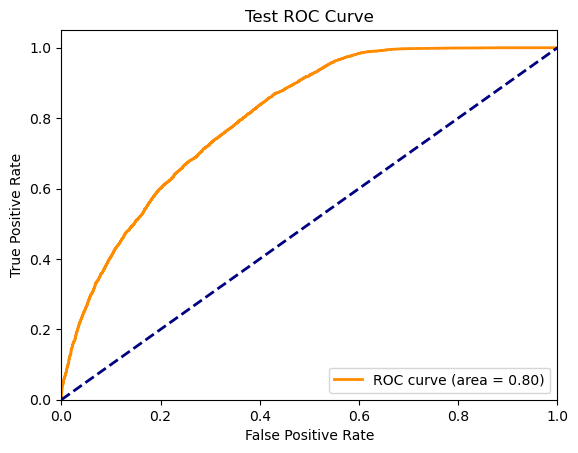

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Flixster dataset
root_path = osp.join('data', 'Flixster')
dataset = IGMCDataset(root=root_path, name='Flixster')
data = dataset[0]

# Ensure edge labels are present and properly sized for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

# Evaluation function
def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

# Function to plot ROC curve
def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve for the test set
plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


Processing...
Done!


Epoch: 1, Loss: 1.3865
Epoch: 2, Loss: 1.3863
Epoch: 3, Loss: 1.3863
Epoch: 4, Loss: 1.3863
Epoch: 5, Loss: 1.3863
Epoch: 6, Loss: 1.3863
Epoch: 7, Loss: 1.3863
Epoch: 8, Loss: 1.3862
Epoch: 9, Loss: 1.3862
Validation AUC: 0.5864, Macro F1: 0.4442, Micro F1: 0.7992
Test AUC: 0.5876, Macro F1: 0.4443, Micro F1: 0.7996


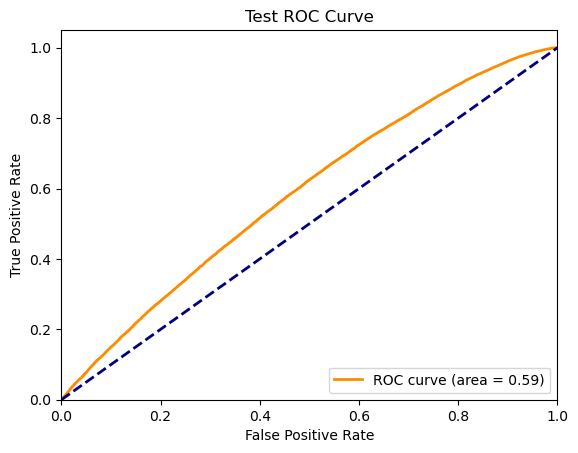

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IGMCDataset
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the Douban dataset
root_path = osp.join('data', 'Douban')
dataset = IGMCDataset(root=root_path, name='Douban')
data = dataset[0]

# Ensure edge labels are present and properly sized for all edge types
def ensure_edge_labels(data, edge_type):
    if 'edge_label' not in data[edge_type]:
        data[edge_type].edge_label = data[edge_type].rating.long()
    elif data[edge_type].edge_label.size(0) != data[edge_type].edge_index.size(1):
        edge_label = data[edge_type].edge_label.long()
        num_labels = edge_label.size(0)
        new_labels = torch.zeros(data[edge_type].edge_index.size(1), dtype=edge_label.dtype)
        new_labels[:num_labels] = edge_label
        data[edge_type].edge_label = new_labels

ensure_edge_labels(data, ('user', 'rates', 'item'))
ensure_edge_labels(data, ('item', 'rated_by', 'user'))

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'item')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

# Evaluation function
def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'item'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['item'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['item'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['item'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

# Function to plot ROC curve
def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve for the test set
plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


In [21]:
from torch_geometric.datasets import AmazonBook
import os.path as osp

# Specify the root directory for the dataset
root_path = osp.join('data', 'AmazonBook')

# Load the AmazonBook dataset with force_reload to ensure proper loading
dataset = AmazonBook(root=root_path, force_reload=True)
data = dataset[0]

# Print the dataset to understand its structure
print(data)


Processing...


HeteroData(
  user={ num_nodes=52643 },
  book={ num_nodes=91599 },
  (user, rates, book)={
    edge_index=[2, 2380730],
    edge_label_index=[2, 603378],
  },
  (book, rated_by, user)={ edge_index=[2, 2380730] }
)


Done!


In [26]:
from torch_geometric.datasets import AmazonBook
import os.path as osp

# Specify the root directory for the dataset
root_path = osp.join('data', 'AmazonBook')

# Load the AmazonBook dataset with force_reload to ensure proper loading
dataset = AmazonBook(root=root_path, force_reload=True)
data = dataset[0]

# Print the overall data structure
print("HeteroData Structure:")
print(data)

# Print node types and counts
print("\nNode types and counts:")
for node_type in data.node_types:
    print(f"{node_type}: {data[node_type].num_nodes}")

# Print edge types and edge index sizes
print("\nEdge types and sizes:")
for edge_type in data.edge_types:
    print(f"{edge_type}: {data[edge_type].edge_index.size()}")

# Print a few sample edges for each edge type
print("\nSample edges:")
for edge_type in data.edge_types:
    print(f"{edge_type}: {data[edge_type].edge_index[:, :5]}")

# Check and print edge labels if available
print("\nEdge labels:")
for edge_type in data.edge_types:
    if 'edge_label_index' in data[edge_type]:
        print(f"{edge_type} labels: {data[edge_type].edge_label_index[:, :5]}")

# Print edge attributes if available
print("\nEdge attributes:")
for edge_type in data.edge_types:
    if 'edge_attr' in data[edge_type]:
        print(f"{edge_type} attributes: {data[edge_type].edge_attr}")

# Print any additional data (e.g., edge labels) if available
print("\nAdditional data:")
for store in data.node_stores + data.edge_stores:
    for attr_name, attr_value in store.items():
        if isinstance(attr_value, dict):
            for key, value in attr_value.items():
                print(f"{key}: {value.size()} - {value[:5]}")
        elif hasattr(attr_value, 'size') and hasattr(attr_value, '__getitem__'):
            print(f"{attr_name}: {attr_value.size()} - {attr_value[:5]}")
        else:
            print(f"{attr_name}: {attr_value}")


Processing...


HeteroData Structure:
HeteroData(
  user={ num_nodes=52643 },
  book={ num_nodes=91599 },
  (user, rates, book)={
    edge_index=[2, 2380730],
    edge_label_index=[2, 603378],
  },
  (book, rated_by, user)={ edge_index=[2, 2380730] }
)

Node types and counts:
user: 52643
book: 91599

Edge types and sizes:
('user', 'rates', 'book'): torch.Size([2, 2380730])
('book', 'rated_by', 'user'): torch.Size([2, 2380730])

Sample edges:
('user', 'rates', 'book'): tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])
('book', 'rated_by', 'user'): tensor([[0, 1, 2, 3, 4],
        [0, 0, 0, 0, 0]])

Edge labels:
('user', 'rates', 'book') labels: tensor([[    0,     0,     0,     0,     0],
        [ 7202,   114,  5612, 27640, 15533]])

Edge attributes:

Additional data:
num_nodes: 52643
num_nodes: 91599
edge_index: torch.Size([2, 2380730]) - tensor([[    0,     0,     0,  ..., 52642, 52642, 52642],
        [    0,     1,     2,  ..., 23186, 10690, 10874]])
edge_label_index: torch.Size([2, 603378]) - te

Done!


In [ ]:
#Good code amazon book
import torch
import torch.nn.functional as F
from torch_geometric.datasets import AmazonBook
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp



# Load the AmazonBook dataset
root_path = osp.join('data', 'AmazonBook')
dataset = AmazonBook(root=root_path, force_reload=True)
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
print(device)

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Move data to device
for node_type in data.node_types:
    data[node_type].x = data[node_type].x.to(device)
for edge_type in data.edge_types:
    data[edge_type].edge_index = data[edge_type].edge_index.to(device)

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'book'), ('book', 'rated_by', 'user')])
train_data, val_data, test_data = transform(data)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin.weight)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lowering the learning rate
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    
    pos_edge_index_user_book = train_data['user', 'rates', 'book'].edge_index
    pos_edge_index_book_user = train_data['book', 'rated_by', 'user'].edge_index

    neg_edge_index_user_book = negative_sampling(edge_index=pos_edge_index_user_book, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index_user_book.size(1)).to(device)
    neg_edge_index_user_book = neg_edge_index_user_book[:, (neg_edge_index_user_book[0] < data['user'].num_nodes) & (neg_edge_index_user_book[1] >= data['user'].num_nodes)]

    neg_edge_index_book_user = negative_sampling(edge_index=pos_edge_index_book_user, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index_book_user.size(1)).to(device)
    neg_edge_index_book_user = neg_edge_index_book_user[:, (neg_edge_index_book_user[1] < data['user'].num_nodes) & (neg_edge_index_book_user[0] >= data['user'].num_nodes)]
    
    pos_out_user_book = (pred['user'][pos_edge_index_user_book[0]] * pred['book'][pos_edge_index_user_book[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out_user_book = (pred['user'][neg_edge_index_user_book[0]] * pred['book'][neg_edge_index_user_book[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_out_book_user = (pred['book'][pos_edge_index_book_user[0] - data['user'].num_nodes] * pred['user'][pos_edge_index_book_user[1]]).sum(dim=1)
    neg_out_book_user = (pred['book'][neg_edge_index_book_user[0] - data['user'].num_nodes] * pred['user'][neg_edge_index_book_user[1]]).sum(dim=1)

    pos_loss_user_book = criterion(pos_out_user_book, torch.ones_like(pos_out_user_book))
    neg_loss_user_book = criterion(neg_out_user_book, torch.zeros_like(neg_out_user_book))

    pos_loss_book_user = criterion(pos_out_book_user, torch.ones_like(pos_out_book_user))
    neg_loss_book_user = criterion(neg_out_book_user, torch.zeros_like(neg_out_book_user))

    loss = pos_loss_user_book + neg_loss_user_book + pos_loss_book_user + neg_loss_book_user
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
        
    pos_edge_index_user_book = data['user', 'rates', 'book'].edge_index
    pos_edge_index_book_user = data['book', 'rated_by', 'user'].edge_index

    neg_edge_index_user_book = negative_sampling(edge_index=pos_edge_index_user_book, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index_user_book.size(1)).to(device)
    neg_edge_index_user_book = neg_edge_index_user_book[:, (neg_edge_index_user_book[0] < data['user'].num_nodes) & (neg_edge_index_user_book[1] >= data['user'].num_nodes)]

    neg_edge_index_book_user = negative_sampling(edge_index=pos_edge_index_book_user, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index_book_user.size(1)).to(device)
    neg_edge_index_book_user = neg_edge_index_book_user[:, (neg_edge_index_book_user[1] < data['user'].num_nodes) & (neg_edge_index_book_user[0] >= data['user'].num_nodes)]
    
    pos_out_user_book = (pred['user'][pos_edge_index_user_book[0]] * pred['book'][pos_edge_index_user_book[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out_user_book = (pred['user'][neg_edge_index_user_book[0]] * pred['book'][neg_edge_index_user_book[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_out_book_user = (pred['book'][pos_edge_index_book_user[0] - data['user'].num_nodes] * pred['user'][pos_edge_index_book_user[1]]).sum(dim=1)
    neg_out_book_user = (pred['book'][neg_edge_index_book_user[0] - data['user'].num_nodes] * pred['user'][neg_edge_index_book_user[1]]).sum(dim=1)

    pos_labels_user_book = torch.ones(pos_out_user_book.size(0)).to(device)
    neg_labels_user_book = torch.zeros(neg_out_user_book.size(0)).to(device)
    
    pos_labels_book_user = torch.ones(pos_out_book_user.size(0)).to(device)
    neg_labels_book_user = torch.zeros(neg_out_book_user.size(0)).to(device)
    
    labels = torch.cat([pos_labels_user_book, neg_labels_user_book, pos_labels_book_user, neg_labels_book_user])
    preds = torch.cat([pos_out_user_book, neg_out_user_book, pos_out_book_user, neg_out_book_user])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plotting the ROC curve
fpr, tpr, _ = roc_curve(test_labels.cpu().numpy(), test_preds.cpu().numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Processing...
Done!


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import AmazonBook
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Check for MPS availability and set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the AmazonBook dataset
root_path = osp.join('data', 'AmazonBook')
dataset = AmazonBook(root=root_path, force_reload=True)
data = dataset[0]

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Move data to device
for node_type in data.node_types:
    data[node_type].x = data[node_type].x.to(device)
for edge_type in data.edge_types:
    data[edge_type].edge_index = data[edge_type].edge_index.to(device)

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'book')])
train_data, val_data, test_data = transform(data)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'book'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index.size(1)).to(device)
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['book'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['book'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'book'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index.size(1)).to(device)
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['book'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['book'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0)).to(device)
    neg_labels = torch.zeros(neg_out.size(0)).to(device)
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')


Using device: mps


Processing...
Done!


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import AmazonBook
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the AmazonBook dataset
root_path = osp.join('data', 'AmazonBook')
dataset = AmazonBook(root=root_path, force_reload=True)
data = dataset[0]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
print(device)

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('user', 'rates', 'book')])
train_data, val_data, test_data = transform(data)

class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=64, out_channels=64, num_layers=3, num_heads=4, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    pos_edge_index = train_data['user', 'rates', 'book'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['book'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['book'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 20):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    pos_edge_index = data['user', 'rates', 'book'].edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(data['user'].num_nodes + data['book'].num_nodes), num_neg_samples=pos_edge_index.size(1))
    
    # Filter out invalid negative samples
    neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < data['user'].num_nodes) & (neg_edge_index[1] >= data['user'].num_nodes)]
    
    pos_out = (pred['user'][pos_edge_index[0]] * pred['book'][pos_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    neg_out = (pred['user'][neg_edge_index[0]] * pred['book'][neg_edge_index[1] - data['user'].num_nodes]).sum(dim=1)
    
    pos_labels = torch.ones(pos_out.size(0))
    neg_labels = torch.zeros(neg_out.size(0))
    
    labels = torch.cat([pos_labels, neg_labels])
    preds = torch.cat([pos_out, neg_out])
    
    auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
    macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
    micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
    
    return auc_score, macro_f1, micro_f1, labels, preds

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')


Processing...
Done!


In [3]:
import torch
from torch_geometric.datasets import IMDB
import os.path as osp

# Load the IMDB dataset
root_path = osp.join('IMDB')
dataset = IMDB(root=root_path)
data = dataset[0]

# Print the basic information about the dataset
print("Dataset: ", dataset)
print("Number of graphs in the dataset: ", len(dataset))
print("Dataset description: ", dataset.__repr__())

# Print the data object to understand its attributes
print("\nData object: ", data)

# Print the number of nodes and edges
print("\nNumber of nodes: ", data.num_nodes)
print("Number of edges: ", data.num_edges)

# Print node feature matrices and edge indices for each node and edge type
for node_type in data.node_types:
    print(f"\nNode type '{node_type}':")
    print(f"Number of nodes: {data[node_type].num_nodes}")
    print(f"Node feature matrix (first 5 nodes): {data[node_type].x[:5]}")

for edge_type in data.edge_types:
    print(f"\nEdge type '{edge_type}':")
    print(f"Edge index: {data[edge_type].edge_index}")
    print(f"Number of edges: {data[edge_type].num_edges}")

# Print the node types
print("\nNode types: ")
print(data.node_types)

# Print the edge types
print("\nEdge types: ")
print(data.edge_types)


Dataset:  IMDB()
Number of graphs in the dataset:  1
Dataset description:  IMDB()

Data object:  HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

Number of nodes:  11616
Number of edges:  34212

Node type 'movie':
Number of nodes: 4278
Node feature matrix (first 5 nodes): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Node type 'director':
Number of nodes: 2081
Node feature matrix (first 5 nodes): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

Epoch: 1, Loss: 2.7747
Epoch: 2, Loss: 2.7718
Epoch: 3, Loss: 2.7698
Epoch: 4, Loss: 2.7658
Epoch: 5, Loss: 2.7581
Epoch: 6, Loss: 2.7620
Epoch: 7, Loss: 2.7438
Epoch: 8, Loss: 2.7359
Epoch: 9, Loss: 2.7210
Epoch: 10, Loss: 2.6913
Epoch: 11, Loss: 2.6935
Epoch: 12, Loss: 2.6535
Epoch: 13, Loss: 2.6633
Epoch: 14, Loss: 2.6461
Epoch: 15, Loss: 2.6156
Epoch: 16, Loss: 2.5923
Epoch: 17, Loss: 2.5428
Epoch: 18, Loss: 2.5478
Epoch: 19, Loss: 2.5335
Validation AUC: 0.7894, Macro F1: 0.6307, Micro F1: 0.6627
Test AUC: 0.7774, Macro F1: 0.6254, Micro F1: 0.6580


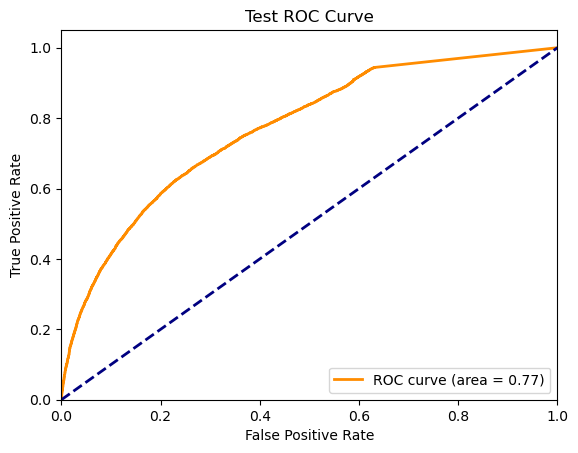

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HGTConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os.path as osp

# Load the IMDB dataset
root_path = osp.join('data', 'IMDB')
dataset = IMDB(root=root_path)
data = dataset[0]

# Initialize node features if not present
for node_type in data.node_types:
    if 'x' not in data[node_type]:
        data[node_type].x = torch.eye(data[node_type].num_nodes)  # Using identity matrix as dummy features

# Split the data into train, validation, and test sets
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False, edge_types=[('movie', 'to', 'director'), ('movie', 'to', 'actor')])
train_data, val_data, test_data = transform(data)

# Define the HGT model
class HGTModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, metadata):
        super(HGTModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        in_channels = {node_type: -1 for node_type in metadata[0]}  # Initialize with dynamic dimensions
        self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        for _ in range(num_layers - 1):
            in_channels = {node_type: hidden_channels for node_type in metadata[0]}  # Update in_channels to hidden_channels
            self.convs.append(HGTConv(in_channels, hidden_channels, metadata, num_heads))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

# Correct metadata format for HGTConv
metadata = (list(data.node_types), list(data.edge_types))

# Initialize the model, optimizer, and loss function
model = HGTModel(hidden_channels=60, out_channels=60, num_layers=2, num_heads=5, metadata=metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict)
    total_loss = 0
    
    for edge_type in [('movie', 'to', 'director'), ('movie', 'to', 'actor')]:
        pos_edge_index = train_data[edge_type].edge_index
        # Number of nodes in the source and target node types
        num_src_nodes = data[edge_type[0]].num_nodes
        num_dst_nodes = data[edge_type[2]].num_nodes
        
        # Negative sampling
        neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(num_src_nodes, num_dst_nodes), num_neg_samples=pos_edge_index.size(1))
        
        # Filter out invalid negative samples
        neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < num_src_nodes) & (neg_edge_index[1] < num_dst_nodes)]
        
        pos_out = (pred[edge_type[0]][pos_edge_index[0]] * pred[edge_type[2]][pos_edge_index[1]]).sum(dim=1)
        neg_out = (pred[edge_type[0]][neg_edge_index[0]] * pred[edge_type[2]][neg_edge_index[1]]).sum(dim=1)
        
        pos_loss = criterion(pos_out, torch.ones_like(pos_out))
        neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
        total_loss += pos_loss + neg_loss
    
    total_loss.backward()
    optimizer.step()
    return total_loss.item()

# Train the model for a specified number of epochs
for epoch in range(1, 20):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

# Evaluation function
def evaluate(data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x_dict, data.edge_index_dict)
    total_auc = 0
    total_macro_f1 = 0
    total_micro_f1 = 0
    all_labels = []
    all_preds = []
    
    for edge_type in [('movie', 'to', 'director'), ('movie', 'to', 'actor')]:
        pos_edge_index = data[edge_type].edge_index
        num_src_nodes = data[edge_type[0]].num_nodes
        num_dst_nodes = data[edge_type[2]].num_nodes
        
        # Negative sampling
        neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=(num_src_nodes, num_dst_nodes), num_neg_samples=pos_edge_index.size(1))
        
        # Filter out invalid negative samples
        neg_edge_index = neg_edge_index[:, (neg_edge_index[0] < num_src_nodes) & (neg_edge_index[1] < num_dst_nodes)]
        
        pos_out = (pred[edge_type[0]][pos_edge_index[0]] * pred[edge_type[2]][pos_edge_index[1]]).sum(dim=1)
        neg_out = (pred[edge_type[0]][neg_edge_index[0]] * pred[edge_type[2]][neg_edge_index[1]]).sum(dim=1)
        
        pos_labels = torch.ones(pos_out.size(0))
        neg_labels = torch.zeros(neg_out.size(0))
        
        labels = torch.cat([pos_labels, neg_labels])
        preds = torch.cat([pos_out, neg_out])
        
        auc_score = roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy())
        macro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='macro')
        micro_f1 = f1_score(labels.cpu().numpy(), (preds > 0).cpu().numpy(), average='micro')
        
        total_auc += auc_score
        total_macro_f1 += macro_f1
        total_micro_f1 += micro_f1
        all_labels.append(labels)
        all_preds.append(preds)
    
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    return total_auc / 2, total_macro_f1 / 2, total_micro_f1 / 2, all_labels, all_preds

# Function to plot ROC curve
def plot_roc_curve(labels, preds, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model on validation and test sets
val_auc, val_macro_f1, val_micro_f1, val_labels, val_preds = evaluate(val_data)
test_auc, test_macro_f1, test_micro_f1, test_labels, test_preds = evaluate(test_data)

print(f'Validation AUC: {val_auc:.4f}, Macro F1: {val_macro_f1:.4f}, Micro F1: {val_micro_f1:.4f}')
print(f'Test AUC: {test_auc:.4f}, Macro F1: {test_macro_f1:.4f}, Micro F1: {test_micro_f1:.4f}')

# Plot ROC curve for the test set
plot_roc_curve(test_labels, test_preds, title='Test ROC Curve')


In [19]:
import torch
from ogb.linkproppred import PygLinkPropPredDataset
import os.path as osp

# Load the ogbl-biokg dataset
path = osp.join('data', 'ogbl-biokg')
dataset = PygLinkPropPredDataset(name='ogbl-biokg', root=path)
data = dataset[0]

# Print basic details about the data
print("Dataset keys:", data.keys())
print("Node types and counts:", data.num_nodes_dict)
print("Edge types and their indices:", data.edge_index_dict.keys())

# Print details for each node type
for node_type, num_nodes in data.num_nodes_dict.items():
    print(f"Node type '{node_type}' has {num_nodes} nodes.")

# Print details for each edge type
for edge_type, edge_index in data.edge_index_dict.items():
    print(f"Edge type {edge_type} with edge indices shape: {edge_index.shape}")
    print(f"Edge index for {edge_type}:\n{edge_index}")

# Check for node features and edge indices
print("Node types in data.num_nodes_dict.keys():", list(data.num_nodes_dict.keys()))
for node_type in data.num_nodes_dict.keys():
    if 'x' in data[node_type]:
        print(f"Node type '{node_type}' has node features with shape {data[node_type]['x'].shape}.")
    else:
        print(f"Node type '{node_type}' has no node features.")

# Extract specific details for 'disease' node type and its features
try:
    print("Details for 'disease' node type:")
    disease_data = data['disease']
    print("Keys in 'disease' data:", list(disease_data.keys()))
    if 'x' in disease_data:
        print(f"'disease' node features shape: {disease_data['x'].shape}")
    else:
        print("'disease' node type has no features.")
except KeyError as e:
    print(f"Error accessing 'disease' node type: {e}")


Dataset keys: ['num_nodes_dict', 'edge_reltype', 'edge_index_dict']
Node types and counts: {'disease': 10687, 'drug': 10533, 'function': 45085, 'protein': 17499, 'sideeffect': 9969}
Edge types and their indices: dict_keys([('disease', 'disease-protein', 'protein'), ('drug', 'drug-disease', 'disease'), ('drug', 'drug-drug_acquired_metabolic_disease', 'drug'), ('drug', 'drug-drug_bacterial_infectious_disease', 'drug'), ('drug', 'drug-drug_benign_neoplasm', 'drug'), ('drug', 'drug-drug_cancer', 'drug'), ('drug', 'drug-drug_cardiovascular_system_disease', 'drug'), ('drug', 'drug-drug_chromosomal_disease', 'drug'), ('drug', 'drug-drug_cognitive_disorder', 'drug'), ('drug', 'drug-drug_cryptorchidism', 'drug'), ('drug', 'drug-drug_developmental_disorder_of_mental_health', 'drug'), ('drug', 'drug-drug_endocrine_system_disease', 'drug'), ('drug', 'drug-drug_fungal_infectious_disease', 'drug'), ('drug', 'drug-drug_gastrointestinal_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_syste

KeyError: 'disease'

# OGBL -MAG

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HGTConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

# Feature Embedding class
class FeatureEmbedding(torch.nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(FeatureEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, node_indices):
        return self.embedding(node_indices)

# HGT Model class
class HGT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, metadata):
        super(HGT, self).__init__()
        self.hgt1 = HGTConv(in_channels, hidden_channels, metadata, num_heads)
        self.hgt2 = HGTConv(hidden_channels, out_channels, metadata, num_heads)

    def forward(self, x_dict, edge_index_dict):
        #print(f"Forward pass with x_dict keys: {x_dict.keys()}")
        #print(f"Forward pass with edge_index_dict keys: {edge_index_dict.keys()}")
        
        x_dict = self.hgt1(x_dict, edge_index_dict)
        #print(f"After HGTConv1, x_dict keys: {x_dict.keys()}")
        
        # Ensure all node types are preserved
        missing_keys = set(metadata[0]) - set(x_dict.keys())
        for key in missing_keys:
            x_dict[key] = torch.zeros_like(next(iter(x_dict.values())))

        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        
        x_dict = self.hgt2(x_dict, edge_index_dict)
        #print(f"After HGTConv2, x_dict keys: {x_dict.keys()}")

        # Ensure all node types are preserved again
        missing_keys = set(metadata[0]) - set(x_dict.keys())
        for key in missing_keys:
            x_dict[key] = torch.zeros_like(next(iter(x_dict.values())))

        return x_dict

# Load the dataset
dataset = PygNodePropPredDataset(name='ogbn-mag')
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
print(device)

# Initialize node embeddings
embedding_dim = 128
entity_types = data.num_nodes_dict.keys()
embeddings = {entity: FeatureEmbedding(data.num_nodes_dict[entity], embedding_dim).to(device) for entity in entity_types}

# Metadata and model setup
metadata = (list(data.num_nodes_dict.keys()), list(data.edge_index_dict.keys()))
print(f"Metadata: {metadata}")

num_heads = 4
model = HGT(embedding_dim, 64, 64, num_heads, metadata).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Function to predict edges
def predict_edge(node_emb1, node_emb2):
    score = torch.sigmoid((node_emb1 * node_emb2).sum(dim=1))
    return score

# Function to get node offsets
def get_offsets(entity_types, data):
    offsets = {}
    current_offset = 0
    for entity in entity_types:
        offsets[entity] = current_offset
        current_offset += data.num_nodes_dict[entity]
    return offsets

# Training function
def train():
    model.train()
    total_loss = 0
    x_dict = {entity: embeddings[entity].embedding.weight for entity in entity_types}
    edge_index_dict = data.edge_index_dict
    offsets = get_offsets(entity_types, data)

    for edge_type in edge_index_dict.keys():
        optimizer.zero_grad()
        src, dst = data.edge_index_dict[edge_type].unbind(0)
        src_offset = offsets[edge_type[0]]
        dst_offset = offsets[edge_type[2]]
        adjusted_edge_index = torch.stack([src + src_offset, dst + dst_offset], dim=0)

        #print(f"Processing edge type: {edge_type}")
        #print(f"Source node type: {edge_type[0]}, Destination node type: {edge_type[2]}")
        #print(f"src_offset: {src_offset}, dst_offset: {dst_offset}")
        #print(f"x_dict keys: {x_dict.keys()}")
        #print(f"edge_index_dict keys: {edge_index_dict.keys()}")

        if src.max().item() >= len(x_dict[edge_type[0]]) or dst.max().item() >= len(x_dict[edge_type[2]]):
            print(f"Index out of bounds for edge type: {edge_type}")
            continue

        out_dict = model(x_dict, edge_index_dict)
        #print(f"Output dictionary keys: {out_dict.keys()}")

        if edge_type[0] not in out_dict or edge_type[2] not in out_dict:
            print(f"Skipping edge type {edge_type} as it is not in the output dictionary")
            continue

        src = src % len(out_dict[edge_type[0]])
        dst = dst % len(out_dict[edge_type[2]])

        out_src = out_dict[edge_type[0]][src]
        out_dst = out_dict[edge_type[2]][dst]
        pos_out = predict_edge(out_src, out_dst)

        neg_src, neg_dst = negative_sampling(adjusted_edge_index, num_neg_samples=src.size(0), method='sparse')
        neg_src = neg_src % len(out_dict[edge_type[0]])
        neg_dst = neg_dst % len(out_dict[edge_type[2]])

        neg_out_src = out_dict[edge_type[0]][neg_src]
        neg_out_dst = out_dict[edge_type[2]][neg_dst]
        neg_out = predict_edge(neg_out_src, neg_out_dst)

        pos_loss = -torch.log(pos_out + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()
        loss = pos_loss + neg_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(edge_index_dict.keys())

# Training loop
# for epoch in range(1, 2):
#     train_loss = train()
#     print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    
# Evaluate function
from sklearn.metrics import roc_curve
def evaluate():
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []

        x_dict = {entity: embeddings[entity].embedding.weight for entity in entity_types}
        edge_index_dict = data.edge_index_dict
        offsets = get_offsets(entity_types, data)

        for edge_type in edge_index_dict.keys():
            src, dst = data.edge_index_dict[edge_type].unbind(0)
            src_offset = offsets[edge_type[0]]
            dst_offset = offsets[edge_type[2]]
            adjusted_edge_index = torch.stack([src + src_offset, dst + dst_offset], dim=0)

            out_dict = model(x_dict, edge_index_dict)
            if edge_type[0] not in out_dict or edge_type[2] not in out_dict:
                continue

            src = src % len(out_dict[edge_type[0]])
            dst = dst % len(out_dict[edge_type[2]])

            out_src = out_dict[edge_type[0]][src]
            out_dst = out_dict[edge_type[2]][dst]
            pos_score = predict_edge(out_src, out_dst)
            y_true.extend([1] * src.size(0))
            y_pred.extend(pos_score.cpu().numpy())

            neg_src, neg_dst = negative_sampling(adjusted_edge_index, num_neg_samples=src.size(0), method='sparse')
            neg_src = neg_src % len(out_dict[edge_type[0]])
            neg_dst = neg_dst % len(out_dict[edge_type[2]])

            neg_out_src = out_dict[edge_type[0]][neg_src]
            neg_out_dst = out_dict[edge_type[2]][neg_dst]
            neg_score = predict_edge(neg_out_src, neg_out_dst)
            y_true.extend([0] * neg_src.size(0))
            y_pred.extend(neg_score.cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        return fpr, tpr, auc_score

# Training loop and evaluation
for epoch in range(1, 3):
    train_loss = train()
    fpr, tpr, auc_score = evaluate()
    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}, AUC: {auc_score:.4f}')
    final_fpr, final_tpr, final_auc_score = fpr, tpr, auc_score  # Store the last epoch's data

# Plot ROC curve only after the last epoch
plt.figure()
plt.plot(final_fpr, final_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {final_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



In [26]:
import torch
from ogb.linkproppred import PygLinkPropPredDataset
import os.path as osp

# Load the ogbl-biokg dataset
path = osp.join('data', 'ogbl-biokg')
dataset = PygLinkPropPredDataset(name='ogbl-biokg', root=path)
data = dataset[0]

# Print basic details about the data
print("Node types and counts:", data.num_nodes_dict)
print("Edge types and their indices:", data.edge_index_dict.keys())

# Example: Accessing edge indices for 'disease-protein' relationship
edge_type = ('disease', 'disease-protein', 'protein')
if edge_type in data.edge_index_dict:
    edge_index = data.edge_index_dict[edge_type]
    print(f"Edge type {edge_type} with edge indices shape: {edge_index.shape}")
    print(f"Sample edge indices for {edge_type}:")
    print(edge_index[:, :10])  # Print first 10 edges
else:
    print(f"Edge type {edge_type} not found in the dataset.")

# Check and print details for each edge type
for edge_type, edge_index in data.edge_index_dict.items():
    print(f"Edge type {edge_type} with edge indices shape: {edge_index.shape}")

# Verify there are no node features
node_types_with_features = ['disease', 'drug', 'function', 'protein', 'sideeffect']
for node_type in node_types_with_features:
    if node_type in data:
        try:
            node_features = data[node_type].x
            print(f"Node type '{node_type}' has node features with shape {node_features.shape}.")
        except KeyError:
            print(f"Node type '{node_type}' does not have node features.")
        except AttributeError:
            print(f"Node type '{node_type}' does not have 'x' attribute.")
    else:
        print(f"Node type '{node_type}' not found in data storage.")


Node types and counts: {'disease': 10687, 'drug': 10533, 'function': 45085, 'protein': 17499, 'sideeffect': 9969}
Edge types and their indices: dict_keys([('disease', 'disease-protein', 'protein'), ('drug', 'drug-disease', 'disease'), ('drug', 'drug-drug_acquired_metabolic_disease', 'drug'), ('drug', 'drug-drug_bacterial_infectious_disease', 'drug'), ('drug', 'drug-drug_benign_neoplasm', 'drug'), ('drug', 'drug-drug_cancer', 'drug'), ('drug', 'drug-drug_cardiovascular_system_disease', 'drug'), ('drug', 'drug-drug_chromosomal_disease', 'drug'), ('drug', 'drug-drug_cognitive_disorder', 'drug'), ('drug', 'drug-drug_cryptorchidism', 'drug'), ('drug', 'drug-drug_developmental_disorder_of_mental_health', 'drug'), ('drug', 'drug-drug_endocrine_system_disease', 'drug'), ('drug', 'drug-drug_fungal_infectious_disease', 'drug'), ('drug', 'drug-drug_gastrointestinal_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_system_diseas

# OGBL BIOKG 

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HGTConv
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score, f1_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

# Feature Embedding class
class FeatureEmbedding(torch.nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(FeatureEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, node_indices):
        return self.embedding(node_indices)

# HGT Model class
class HGT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, metadata):
        super(HGT, self).__init__()
        self.hgt1 = HGTConv(in_channels, hidden_channels, metadata, num_heads)
        self.hgt2 = HGTConv(hidden_channels, out_channels, metadata, num_heads)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.hgt1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = self.hgt2(x_dict, edge_index_dict)
        return x_dict

# Load the dataset
dataset = PygLinkPropPredDataset(name='ogbl-biokg')
split_edge = dataset.get_edge_split()
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
print(f"Using device: {device}")

# Initialize node embeddings
embedding_dim = 128
entity_types = data.num_nodes_dict.keys()
embeddings = {entity: FeatureEmbedding(data.num_nodes_dict[entity], embedding_dim).to(device) for entity in entity_types}

# Metadata and model setup
metadata = (list(data.num_nodes_dict.keys()), list(data.edge_index_dict.keys()))
num_heads = 4
model = HGT(embedding_dim, 64, 64, num_heads, metadata).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to predict edges
def predict_edge(node_emb1, node_emb2):
    score = torch.sigmoid((node_emb1 * node_emb2).sum(dim=1))
    return score

# Function to get node offsets
def get_offsets(entity_types, data):
    offsets = {}
    current_offset = 0
    for entity in entity_types:
        offsets[entity] = current_offset
        current_offset += data.num_nodes_dict[entity]
    return offsets

# Training function
def train():
    model.train()
    total_loss = 0
    x_dict = {entity: embeddings[entity].embedding.weight for entity in entity_types}
    edge_index_dict = data.edge_index_dict
    offsets = get_offsets(entity_types, data)

    for edge_type in edge_index_dict.keys():
        optimizer.zero_grad()
        src, dst = data.edge_index_dict[edge_type].unbind(0)
        src_offset = offsets[edge_type[0]]
        dst_offset = offsets[edge_type[2]]
        adjusted_edge_index = torch.stack([src + src_offset, dst + dst_offset], dim=0)

        out_dict = model(x_dict, edge_index_dict)
        out_src = out_dict[edge_type[0]][src]
        out_dst = out_dict[edge_type[2]][dst]
        pos_out = predict_edge(out_src, out_dst)

        neg_src, neg_dst = negative_sampling(adjusted_edge_index, num_neg_samples=src.size(0), method='sparse')
        neg_src = neg_src % len(out_dict[edge_type[0]])
        neg_dst = neg_dst % len(out_dict[edge_type[2]])

        neg_out_src = out_dict[edge_type[0]][neg_src]
        neg_out_dst = out_dict[edge_type[2]][neg_dst]
        neg_out = predict_edge(neg_out_src, neg_out_dst)

        pos_loss = -torch.log(pos_out + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()
        loss = pos_loss + neg_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(edge_index_dict.keys())

# Evaluation function
def evaluate():
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []

        x_dict = {entity: embeddings[entity].embedding.weight for entity in entity_types}
        edge_index_dict = data.edge_index_dict
        offsets = get_offsets(entity_types, data)

        for edge_type in edge_index_dict.keys():
            src, dst = data.edge_index_dict[edge_type].unbind(0)
            src_offset = offsets[edge_type[0]]
            dst_offset = offsets[edge_type[2]]
            adjusted_edge_index = torch.stack([src + src_offset, dst + dst_offset], dim=0)

            out_dict = model(x_dict, edge_index_dict)
            out_src = out_dict[edge_type[0]][src]
            out_dst = out_dict[edge_type[2]][dst]
            pos_score = predict_edge(out_src, out_dst)
            y_true.extend([1] * src.size(0))
            y_pred.extend(pos_score.cpu().numpy())

            neg_src, neg_dst = negative_sampling(adjusted_edge_index, num_neg_samples=src.size(0), method='sparse')
            neg_src = neg_src % len(out_dict[edge_type[0]])
            neg_dst = neg_dst % len(out_dict[edge_type[2]])
            neg_out_src = out_dict[edge_type[0]][neg_src]
            neg_out_dst = out_dict[edge_type[2]][neg_dst]
            neg_score = predict_edge(neg_out_src, neg_out_dst)
            y_true.extend([0] * neg_src.size(0))
            y_pred.extend(neg_score.cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        auc_bio = roc_auc_score(y_true, y_pred)
        y_pred_binary = (y_pred > 0.5).astype(int)
        macro_f1_bio = f1_score(y_true, y_pred_binary, average='macro')
        micro_f1_bio = f1_score(y_true, y_pred_binary, average='micro')
        fpr_bio, tpr_bio, _ = roc_curve(y_true, y_pred)

    return auc_bio, macro_f1_bio, micro_f1_bio, y_true, y_pred, fpr_bio, tpr_bio

# Training loop
for epoch in range(1, 4):
    train_loss = train()
    auc_bio, macro_f1_bio, micro_f1_bio, y_true, y_pred, fpr_bio, tpr_bio = evaluate()
    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}, AUC: {auc_bio:.4f}, Macro F1: {macro_f1_bio:.4f}, Micro F1: {micro_f1_bio:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr_bio, tpr_bio, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_bio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

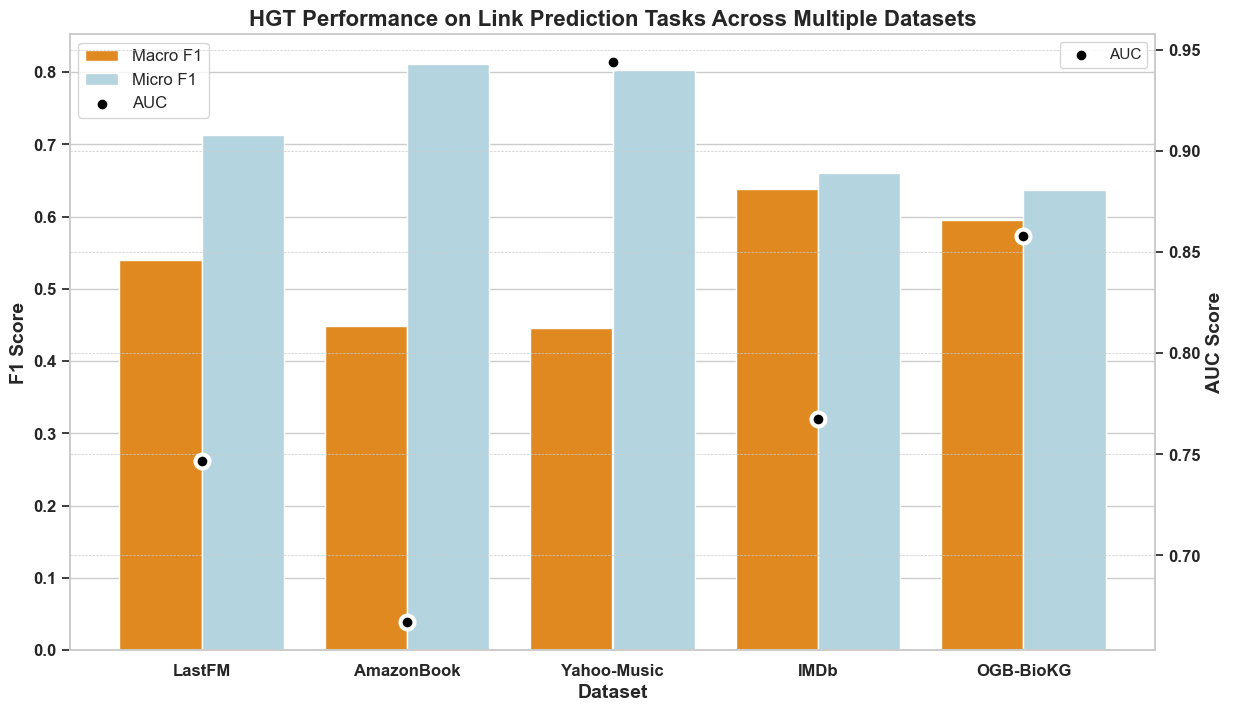

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    "Dataset": ["LastFM", "AmazonBook", "Yahoo-Music", "IMDb", "OGB-BioKG"],
    "AUC": [0.7465, 0.6669, 0.9440, 0.7676, 0.8578],
    "Macro F1": [0.5406, 0.4481, 0.4453, 0.6384, 0.5958],
    "Micro F1": [0.7124, 0.8118, 0.8029, 0.6602, 0.6372],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Create the bar plot for F1 scores
df_melted = df.melt(id_vars="Dataset", value_vars=["Macro F1", "Micro F1"], var_name="Metric", value_name="Score")
bar_plot = sns.barplot(x="Dataset", y="Score", hue="Metric", data=df_melted, ax=ax1, palette=["darkorange", "lightblue"])

# Add title and labels for the bar plot
bar_plot.set_title("HGT Performance on Link Prediction Tasks Across Multiple Datasets", fontsize=16, fontweight='bold')
bar_plot.set_xlabel("Dataset", fontsize=14, fontweight='bold')
bar_plot.set_ylabel("F1 Score", fontsize=14, fontweight='bold')

# Create a second y-axis for the AUC line plot
ax2 = ax1.twinx()
line_plot = sns.scatterplot(x="Dataset", y="AUC", data=df, color='black', s=100, ax=ax2, marker='o', linewidth=3, label="AUC")

# Add labels for the AUC line plot
line_plot.set_ylabel("AUC Score", fontsize=14, fontweight='bold')

# Customize the appearance of the AUC points
for line in line_plot.get_lines():
    line.set_linestyle('')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc="upper left", fontsize=12)

# Customize the appearance of the plot
plt.setp(ax1.get_xticklabels(), fontsize=12, fontweight='bold')
plt.setp(ax1.get_yticklabels(), fontsize=12, fontweight='bold')
plt.setp(ax2.get_yticklabels(), fontsize=12, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


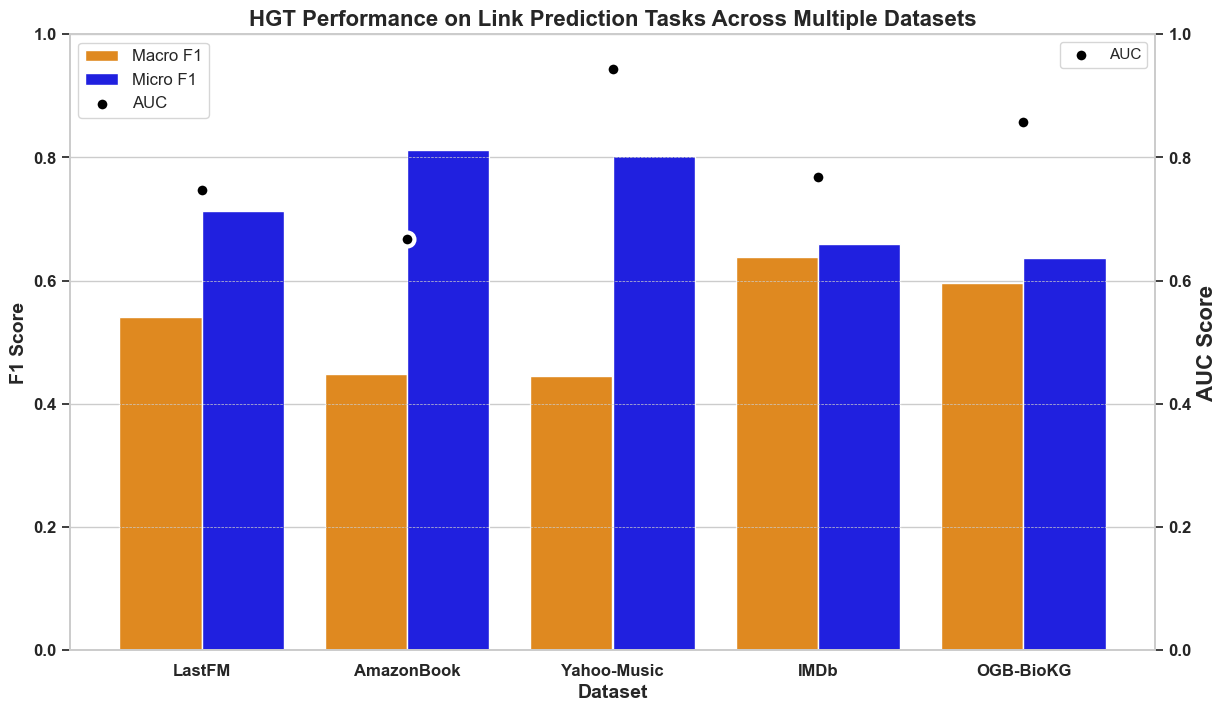

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    "Dataset": ["LastFM", "AmazonBook", "Yahoo-Music", "IMDb", "OGB-BioKG"],
    "AUC": [0.7465, 0.6669, 0.9440, 0.7676, 0.8578],
    "Macro F1": [0.5406, 0.4481, 0.4453, 0.6384, 0.5958],
    "Micro F1": [0.7124, 0.8118, 0.8029, 0.6602, 0.6372],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Create the bar plot for F1 scores
df_melted = df.melt(id_vars="Dataset", value_vars=["Macro F1", "Micro F1"], var_name="Metric", value_name="Score")
bar_plot = sns.barplot(x="Dataset", y="Score", hue="Metric", data=df_melted, ax=ax1, palette=["darkorange", "blue"])

# Add title and labels for the bar plot
bar_plot.set_title("HGT Performance on Link Prediction Tasks Across Multiple Datasets", fontsize=16, fontweight='bold')
bar_plot.set_xlabel("Dataset", fontsize=14, fontweight='bold')
bar_plot.set_ylabel("F1 Score", fontsize=14, fontweight='bold')
bar_plot.set_ylim(0, 1)

# Create a second y-axis for the AUC line plot
ax2 = ax1.twinx()
line_plot = sns.scatterplot(x="Dataset", y="AUC", data=df, color='black', s=100, ax=ax2, marker='o', linewidth=3, label="AUC")

# Add labels for the AUC line plot
line_plot.set_ylabel("AUC Score", fontsize=16, fontweight='bold')
line_plot.set_ylim(0, 1)

# Customize the appearance of the AUC points
for line in line_plot.get_lines():
    line.set_linestyle('')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc="upper left", fontsize=12)

# Customize the appearance of the plot
plt.setp(ax1.get_xticklabels(), fontsize=12, fontweight='bold')
plt.setp(ax1.get_yticklabels(), fontsize=12, fontweight='bold')
plt.setp(ax2.get_yticklabels(), fontsize=12, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()
